In [1]:
import os
import sys
import glob
import yaml
import pickle
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set('talk')
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [2]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

## read data

In [3]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v3/train_10000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

# with open(root_dir/'2kaido_wifi_dataset_v3/test_10000_7.pkl', 'rb') as f:
#   test_df = pickle.load(f)


In [4]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32, 'timediff':np.int})
# test_df = test_df.astype({'timestamp':int})
train_df['site_path_timestamp'] = train_df['site_id'] + "_" + train_df['path'] + '_' + train_df['timestamp'].astype(str)

In [8]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions    
    
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-7e408f106d62>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if current_state is 'above':


In [9]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [12]:
def calc_rel_positions_for_train(path_df):   
    
    site = path_df['site'].unique()[0]
    floor = path_df['floor_str'].unique()[0]
    path = path_df['path'].unique()[0]
    
    T_ref  = path_df['timestamp'].astype(int).values
    xy_hat = path_df[['x', 'y']].values

    INPUT_PATH = '../../input/indoor-location-navigation'
    example = read_data_file(f'{INPUT_PATH}/train/{site}/{floor}/{path}.txt')

    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    # deltaの最初にはゼロが入る
    if T_ref[-1] > rel_positions[-1, 0]:  # deltaの最後のtimestampよりwaypointのtimestampが多い場合最後は０埋め
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)

    T_rel = rel_positions[:, 0]  # deltaのtimestamp
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    delta = np.concatenate([np.array([[0, 0]]), delta_xy_hat])  # 00はstart地点
    path_df['sensor_delta_x'] = delta[:, 0]
    path_df['sensor_delta_y'] = delta[:, 1]
    return path_df


def calc_rel_positions_for_test(path_df):   
    
    # site = path_df['site'].unique()[0]
    # floor = path_df['floor_str'].unique()[0]
    path = path_df['path'].unique()[0]
    
    T_ref  = path_df['timestamp'].astype(int).values
    # xy_hat = path_df[['x', 'y']].values

    INPUT_PATH = '../../input/indoor-location-navigation'
    example = read_data_file(f'{INPUT_PATH}/test/{path}.txt')

    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    # deltaの最初にはゼロが入る
    if T_ref[-1] > rel_positions[-1, 0]:  # deltaの最後のtimestampよりwaypointのtimestampが多い場合最後は０埋め
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)

    T_rel = rel_positions[:, 0]  # deltaのtimestamp
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    delta = np.concatenate([np.array([[0, 0]]), delta_xy_hat])  # 00はstart地点
    path_df['sensor_delta_x'] = delta[:, 0]
    path_df['sensor_delta_y'] = delta[:, 1]
    return path_df

## train

In [ ]:
train
df = train_df.groupby('site_path_timestamp')[['x', 'y']].mean().reset_index()
df['site'] = df['site_path_timestamp'].str.split("_", expand=True)[0]
df['path'] = df['site_path_timestamp'].str.split("_", expand=True)[1]
df['timestamp'] = df['site_path_timestamp'].str.split("_", expand=True)[2]
df = df.merge(train_df[['site_path_timestamp', 'floor_str']].drop_duplicates(), on='site_path_timestamp')
df

In [11]:
dfs = []
for path, path_df in tqdm(df.groupby('path')):
    path_df = calc_rel_positions_for_train(path_df)
    dfs.append(path_df)
delta_df = pd.concat(dfs)

100%|██████████| 10826/10826 [1:09:56<00:00,  2.58it/s] 


In [12]:
dfs2 = []
for path, path_df in tqdm(delta_df.groupby('path')):
    path_df['delta_x'] = path_df['x'] - path_df['x'].shift(1)
    path_df['delta_y'] = path_df['y'] - path_df['y'].shift(1)
    dfs2.append(path_df)
delta_df2 = pd.concat(dfs2)

100%|██████████| 10826/10826 [00:09<00:00, 1195.37it/s]


In [13]:
delta_df2 = delta_df2.fillna(0)
delta_df2

,site_path_timestamp,x,y,site,path,timestamp,floor_str,sensor_delta_x,sensor_delta_y,delta_x,delta_y
2461,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,198.052063,93.971237,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560500995805,F3,0.000000,0.000000,0.000000,0.000000
2462,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,180.073349,89.948959,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560501011427,F3,-14.186333,-3.799168,-17.978714,-4.022278
2463,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,180.073349,89.948959,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501353313,F3,0.000000,0.000000,0.000000,0.000000
2464,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501359897,F3,0.596185,-5.213942,1.274261,-5.645935
2465,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,179.019287,79.741631,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501366899,F3,-1.785963,-4.267227,-2.328323,-4.561394
...,...,...,...,...,...,...,...,...,...,...,...
2456,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,49.308346,187.129456,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483574917,B1,-5.293830,2.851582,-5.835197,1.488266
2457,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,42.038811,188.210541,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483580134,B1,-4.928372,2.852852,-7.269535,1.081085
2458,5a0546857ecc773753327266_5e15bf941506f2000638f...,107.938766,148.184357,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483469045,B1,0.000000,0.000000,0.000000,0.000000
2459,5a0546857ecc773753327266_5e15bf941506f2000638f...,106.659012,154.629517,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483477240,B1,-2.308700,5.061228,-1.279755,6.445160


In [14]:
delta_df2.to_csv('delta_magn_train.csv', index=False)

## test

In [19]:
df = pd.read_csv('../../input/indoor-location-navigation/sample_submission.csv')
simple_accurate_99 = pd.read_csv('../../input/simple-99-accurate-floor-model/submission.csv')[['site_path_timestamp', 'floor']]
df['floor'] = simple_accurate_99['floor']
df['path'] = df['site_path_timestamp'].str.split('_', expand=True)[1]
df['timestamp'] = df['site_path_timestamp'].str.split('_', expand=True)[2]
df

,site_path_timestamp,floor,x,y,path,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0,046cfa46be49fc10834815c6,0000000015326
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0,046cfa46be49fc10834815c6,0000000018763
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0,046cfa46be49fc10834815c6,0000000022328
...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,75.0,75.0,fd64de8c4a2fc5ebb0e9f412,0000000082589
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,75.0,75.0,fd64de8c4a2fc5ebb0e9f412,0000000085758
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,75.0,75.0,fd64de8c4a2fc5ebb0e9f412,0000000090895
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,75.0,75.0,fd64de8c4a2fc5ebb0e9f412,0000000096899


In [20]:
dfs = []
for path, path_df in tqdm(df.groupby('path')):
    path_df = calc_rel_positions_for_test(path_df)
    dfs.append(path_df)
delta_df = pd.concat(dfs)

100%|██████████| 626/626 [09:21<00:00,  1.11it/s]


In [21]:
dfs2 = []
for path, path_df in tqdm(delta_df.groupby('path')):
    path_df['delta_x'] = path_df['x'] - path_df['x'].shift(1)
    path_df['delta_y'] = path_df['y'] - path_df['y'].shift(1)
    dfs2.append(path_df)
delta_df2 = pd.concat(dfs2)

100%|██████████| 626/626 [00:00<00:00, 1219.73it/s]


In [22]:
delta_df2 = delta_df2.fillna(0)
delta_df2

,site_path_timestamp,floor,x,y,path,timestamp,sensor_delta_x,sensor_delta_y,delta_x,delta_y
7165,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,75.0,75.0,00ff0c9a71cc37a2ebdd0f05,0000000000010,0.000000,0.000000,0.0,0.0
7166,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,75.0,75.0,00ff0c9a71cc37a2ebdd0f05,0000000004048,-3.093593,0.646095,0.0,0.0
7167,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,75.0,75.0,00ff0c9a71cc37a2ebdd0f05,0000000012526,3.157146,-2.265768,0.0,0.0
7168,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,75.0,75.0,00ff0c9a71cc37a2ebdd0f05,0000000025542,-3.810098,0.971473,0.0,0.0
7169,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,75.0,75.0,00ff0c9a71cc37a2ebdd0f05,0000000037134,2.242864,-1.558112,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
294,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-1,75.0,75.0,ffcd9524c80c0fa5bb859eaf,0000000035117,6.353211,4.429667,0.0,0.0
295,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-1,75.0,75.0,ffcd9524c80c0fa5bb859eaf,0000000041230,-3.084860,1.619427,0.0,0.0
296,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-1,75.0,75.0,ffcd9524c80c0fa5bb859eaf,0000000051634,1.462828,-6.944950,0.0,0.0
297,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-1,75.0,75.0,ffcd9524c80c0fa5bb859eaf,0000000060483,-3.315076,-6.972902,0.0,0.0


In [23]:
delta_df2.to_csv('delta_magn_test.csv', index=False)

## deltaの(error)を計算

In [15]:
delta = pd.read_csv("delta_magn.csv")
delta

,site_path_timestamp,x,y,site,path,timestamp,floor_str,sensor_delta_x,sensor_delta_y,delta_x,delta_y
0,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,198.052060,93.971240,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560500995805,F3,0.000000,0.000000,0.000000,0.000000
1,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,180.073350,89.948960,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,1560501011427,F3,-14.186333,-3.799168,-17.978714,-4.022278
2,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,180.073350,89.948960,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501353313,F3,0.000000,0.000000,0.000000,0.000000
3,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501359897,F3,0.596185,-5.213942,1.274261,-5.645935
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,179.019290,79.741630,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,1560501366899,F3,-1.785963,-4.267227,-2.328323,-4.561394
...,...,...,...,...,...,...,...,...,...,...,...
71221,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483574917,B1,-5.293830,2.851582,-5.835197,1.488266
71222,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,42.038810,188.210540,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,1578483580134,B1,-4.928372,2.852852,-7.269535,1.081085
71223,5a0546857ecc773753327266_5e15bf941506f2000638f...,107.938770,148.184360,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483469045,B1,0.000000,0.000000,0.000000,0.000000
71224,5a0546857ecc773753327266_5e15bf941506f2000638f...,106.659010,154.629520,5a0546857ecc773753327266,5e15bf941506f2000638fec5,1578483477240,B1,-2.308700,5.061228,-1.279755,6.445160


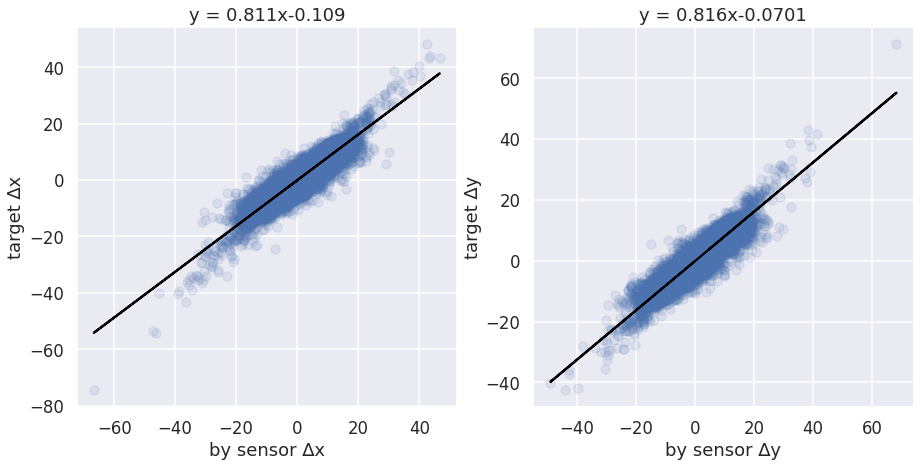

In [16]:
from sklearn import linear_model

target_x = delta["delta_x"].values.reshape(-1,1)
pred_x = delta["sensor_delta_x"].values.reshape(-1,1)
target_y = delta["delta_y"].values.reshape(-1,1)
pred_y = delta["sensor_delta_y"].values.reshape(-1,1)

reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(pred_x, reg1.predict(pred_x), color='black')
ax1.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('by sensor ∆x')
ax1.set_ylabel('target ∆x')
ax1.set_title('y = {:.3g}x{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

reg2 = linear_model.LinearRegression()
reg2.fit(pred_y, target_y)
ax2 = fig.add_subplot(122)
ax2.plot(pred_y, reg1.predict(pred_y), color='black')
ax2.scatter(pred_y, target_y, alpha=0.1)
ax2.set_xlabel('by sensor ∆y')
ax2.set_ylabel('target ∆y')
ax2.set_title('y = {:.3g}x{:.3g}'.format(reg2.coef_[0][0], reg2.intercept_[0]))
# plt.savefig("delta_all.png")

## siteごとに上の可視化を行なってみる。

In [17]:
site_list = delta['site'].unique()

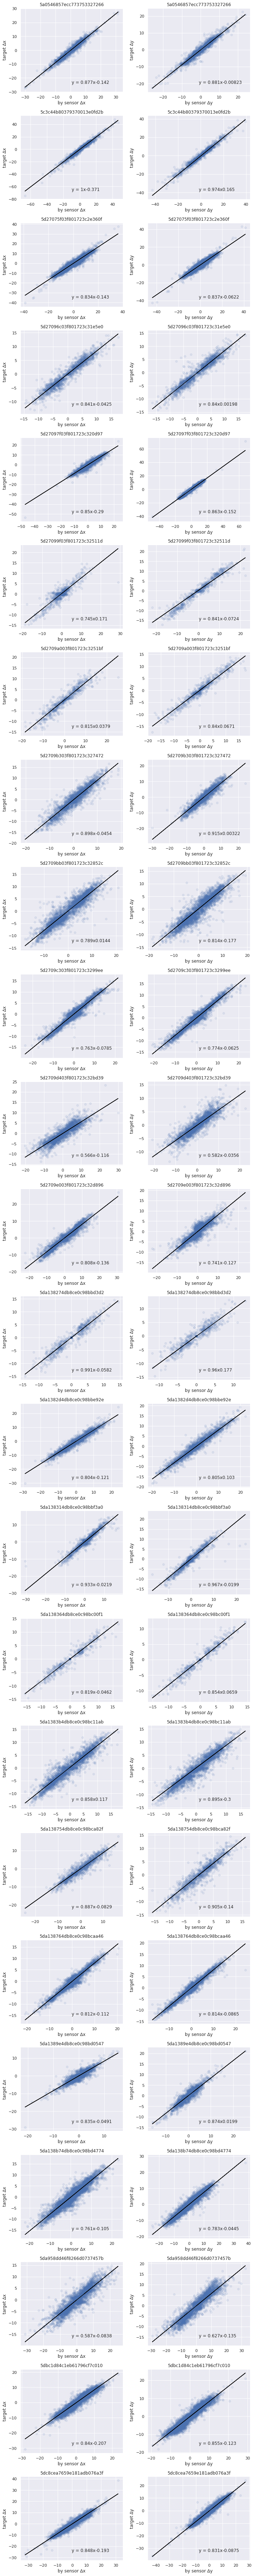

In [18]:
from sklearn import linear_model
delta_x_dict = {}
delta_y_dict = {}
fig = plt.figure(figsize=(10, 100))
sns.set('notebook')
for i, (site, df) in enumerate(delta.groupby('site')):
    target_x = df["delta_x"].values.reshape(-1,1)
    pred_x = df["sensor_delta_x"].values.reshape(-1,1)
    target_y = df["delta_y"].values.reshape(-1,1)
    pred_y = df["sensor_delta_y"].values.reshape(-1,1)
    
    # x
    reg1 = linear_model.LinearRegression()
    reg1.fit(pred_x, target_x)

    ax = fig.add_subplot(24, 2, 2*(i+1)-1)
    ax.plot(pred_x, reg1.predict(pred_x), color='black')
    ax.scatter(pred_x, target_x, alpha=0.1)
    ax.set_xlabel('by sensor ∆x')
    ax.set_ylabel('target ∆x')
    plt.text(0.5,0.1, 'y = {:.3g}x{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]),transform=ax.transAxes)
    ax.set_title('{}'.format(site))
    delta_x_dict[site] = round(reg1.coef_[0][0], 3)
    
    # y
    reg2 = linear_model.LinearRegression()
    reg2.fit(pred_y, target_y)
    ax = fig.add_subplot(24,2,2*(i+1))
    ax.plot(pred_y, reg1.predict(pred_y), color='black')
    ax.scatter(pred_y, target_y, alpha=0.1)
    ax.set_xlabel('by sensor ∆y')
    ax.set_ylabel('target ∆y')
    plt.text(0.5,0.1, 'y = {:.3g}x{:.3g}'.format(reg2.coef_[0][0], reg2.intercept_[0]),transform=ax.transAxes)
    ax.set_title('{}'.format(site))
    delta_y_dict[site] = round(reg2.coef_[0][0], 3)
plt.tight_layout()
plt.savefig("delta_magn_site.png")

In [19]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [20]:
pickle_dump(delta_x_dict, 'delta_magn_x_coeff.pkl')
pickle_dump(delta_y_dict, 'delta_magn_y_coeff.pkl')